<a href="https://colab.research.google.com/github/RuthlessActuary2023/CAS-RPM-2025-Python-Workshop/blob/main/2025_CAS_RPM_Python_Lesson_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 7: Building a Gradient Boosting Machine (GBM) with XGBoost

## Import packages/data & paste functions

In [ ]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns",25)
pd.set_option("display.max_rows",250)
pd.options.display.float_format = '{:,.2f}'.format

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from urllib.request import urlopen
import json

import random
from patsy import dmatrices
import statsmodels.api as sm

# new
import xgboost as xgb
import plotly.express as px
import shap

In [ ]:
# Code to clone the github repo into colab
!pip install gitpython
import git
import os

repo_url = 'https://github.com/RuthlessActuary2023/CAS-RPM-2025-Python-Workshop.git'
repo_dir = '/content/your-repo'

# Clone if it doesn’t already exist
if not os.path.exists(repo_dir):
    git.Repo.clone_from(repo_url, repo_dir)

In [ ]:
repo_dir = '/content/your-repo'
data5 = pd.read_feather(repo_dir + '/data5.ftr')

In [ ]:
# Code from Lesson 6 to create train and test

remove_fields = ['ep_bi','ee_bi','incloss_bi','cc_bi','ep_col','cc_col','zip','pol_id','vin_id','Date']

print(data5.shape)
for i in remove_fields:
    del data5[i]

data6 = data5.loc[data5['incloss_col'] >= 0].copy()
data6['pp'] = data6['incloss_col']/data6['ee_col']

def mad_tt_split(data,train_size):
    np.random.seed(seed=42)
    data['rand'] = np.random.randint(1, 101, data.shape[0])/100

    global data1_train, data1_test # make these 2 dataframes we are about to create have global scope instead of local (local mean inside the function only)
    data1_train = data.loc[data['rand'] <= train_size].copy()
    data1_test = data.loc[data['rand'] > train_size].copy()

    del data1_train['rand']
    del data1_test['rand']

mad_tt_split(data6,.80)

(100443, 68)


In [ ]:
data1_train.head()

,pol_eff_year,ee_col,incloss_col,modelyear,credit,commute_flag,veh_count_box,driver_count_box,veh_age_box,coll_symb_ntile,limit_bi,ded_coll,...,diploma_ntile,pop_density_ntile,unemployment_ntile,modelyear_null_flag,Modeled_Annual_Mileage_null_flag,Estimated_Current_Mileage_null_flag,Annual_Mileage_Estimate_null_flag,Number_of_Titling_Transactions_null_flag,LOO_years_null_flag,curr_owner_odo_cnt_null_flag,all_owner_odo_cnt_null_flag,pp
0,2015,1.00,0.00,"2,010.00",3,0,1,1,5,36,50,500,...,52.00,58.00,51.00,0,0,0,1,0,0,0,0,0.00
2,2014,1.00,0.00,"2,010.00",4,0,1,1,4,36,50,500,...,52.00,58.00,51.00,0,0,0,0,0,0,0,0,0.00
3,2016,1.00,0.00,"2,010.00",3,0,1,1,6,36,50,500,...,52.00,58.00,51.00,0,0,0,0,0,0,0,0,0.00
4,2014,0.17,0.00,"2,007.00",4,0,1,1,7,36,50,500,...,52.00,58.00,51.00,0,0,1,1,0,0,0,0,0.00
5,2014,0.16,0.00,"2,013.00",7,1,1,1,1,78,50,500,...,52.00,58.00,51.00,0,0,0,0,0,0,0,0,0.00


In [ ]:
### Functions from lesson 6

def resid_plot(data,feature,act,pred,weight):
    x = data.groupby([feature]).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    x['act'] = x[act]/x[weight]
    x['pred'] = x[pred]/x[weight]

    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()

    y_max = np.where(x['act'].max() > x['pred'].max(),x['act'].max(),x['pred'].max())*1.20
    ax2.set_ylim(0,y_max)

    x[weight].plot.bar(stacked=False, ax=ax, alpha=0.6)
    x['act'].plot(kind='line', ax=ax2, marker='o',linewidth = 0, legend='act')
    x['pred'].plot(kind='line', ax=ax2, marker='o', legend='pred')

    plt.xticks(ticks = x.index, labels = x[feature])

    ax.set(ylabel=weight, title = feature)
    plt.show()

def lift_chart(test_data, act, pred, weight, bins):
    test_data['decile'] = (round(test_data.sort_values(by = 'pred')[weight].cumsum()/test_data[weight].sum(),2)*bins).apply(np.floor)
    test_data['decile'] = np.where(test_data['decile'] + 1 > bins ,bins,test_data['decile'] + 1)
    x = test_data.groupby(['decile'], dropna = False).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()

    x['act'] = x[act]/x[weight]
    x['pred'] = x[pred]/x[weight]
    x.drop(columns = [act,pred], inplace = True)

    dfg = x
    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()

    y_min = np.where(dfg['act'].min() < dfg['pred'].min(),dfg['act'].min(),dfg['pred'].min())*.95
    y_max = np.where(dfg['act'].max() > dfg['pred'].max(),dfg['act'].max(),dfg['pred'].max())*1.05
    ax2.set_ylim(y_min,y_max)

    dfg[weight].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='act')
    dfg['pred'].plot(kind='line', ax=ax2, marker='o', legend='pred')
    plt.show()
    print(x)

## XGBoost first fit

In [ ]:
# First fit GBM manually with basic parameters

tweedie_p = 1.5
bmf = .10
max_depth = 6
base_score = data1_train['incloss_col'].sum()/data1_train['ee_col'].sum()
num_round = 50 # not referenced in params but is given separately

params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': tweedie_p,
    'learning_rate': bmf,
    'verbosity': 1,
    'max_depth': max_depth,
    'base_score': base_score,
#     'monotone_constraints': xgb_mono(monotone_constraint)
}

# def xgb_mono(x):
#         return str(x).replace('[','(').replace(']',')')

### commented out monotone constraints to save time - input is a list in the format of [0,1,-1,...,0,0,0] where the sign of the number in the list is the direction desired.  0 denotes no constraint.
### Make sure you send the list in the same order as the data columns.

weights = 'ee_col'
drop_cols = ['ee_col','incloss_col','pp']

# train and test design matrices
weight_train = data1_train[weights]
dtrain = xgb.DMatrix(data1_train.drop(drop_cols, axis=1), label=data1_train['pp'], weight=weight_train)

weight_test = data1_test[weights]
dtest = xgb.DMatrix(data1_test.drop(drop_cols, axis=1), label=data1_test['pp'])

# Fit
model_xgb = xgb.train(params, dtrain, num_round)

#Predictions
ypred_test = model_xgb.predict(dtest)
ypred_train = model_xgb.predict(dtrain)

# make a copy so our original data stays the same
# Apply Predictions to train and test data for evaluation
out_train = data1_train.copy()
out_train['pred'] = ypred_train
out_train['pred_loss'] = out_train['pred'] * out_train['ee_col']

out_test = data1_test.copy()
out_test['pred'] = ypred_test
out_test['pred_loss'] = out_test['pred'] * out_test['ee_col']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

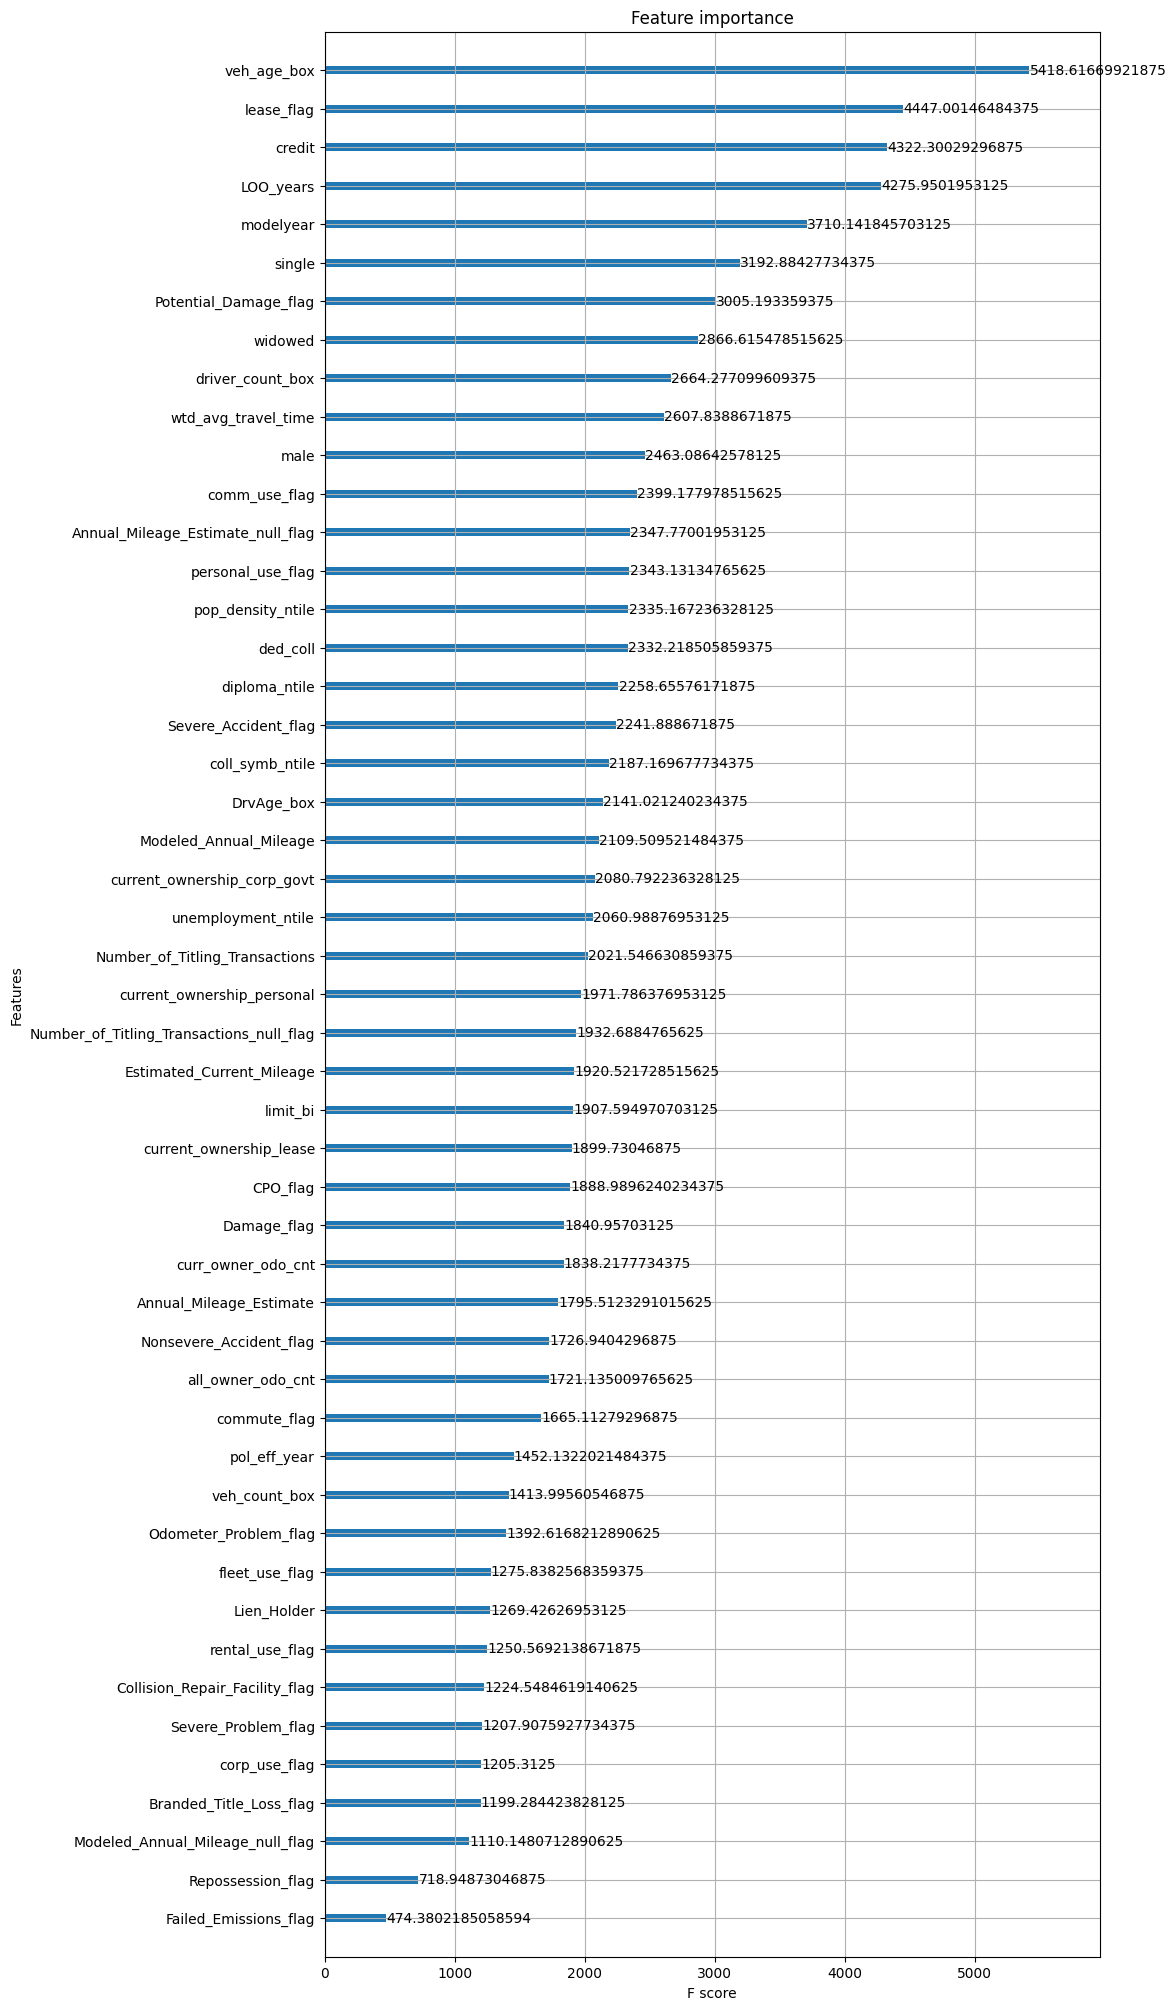

In [ ]:
# plot_importance (first very basic importance display)

fig, ax = plt.subplots(figsize=(10, 25))
xgb.plot_importance(model_xgb, importance_type = 'gain', ax=ax)

# article about importance types: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

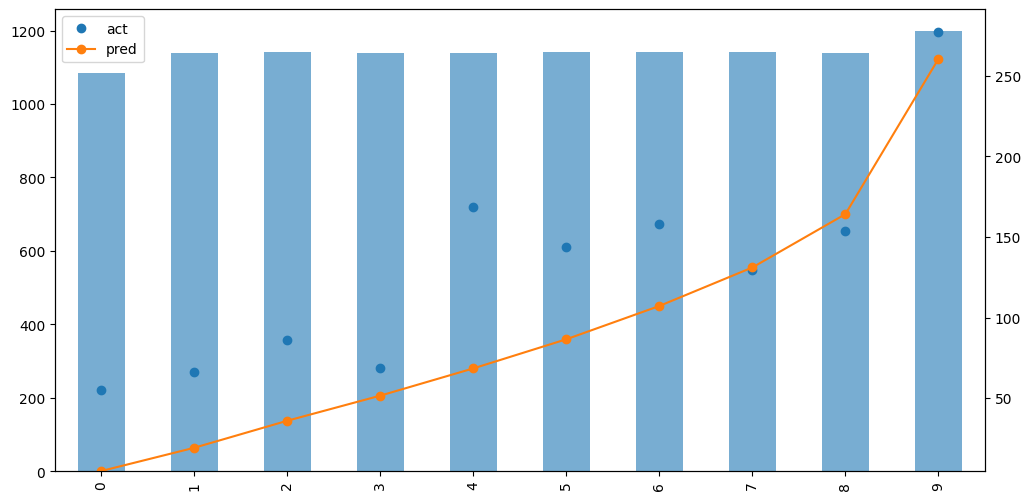

   decile   ee_col    act   pred
0    1.00 1,083.18  54.99   5.00
1    2.00 1,139.84  66.19  19.42
2    3.00 1,140.61  86.05  36.16
3    4.00 1,139.96  69.07  51.72
4    5.00 1,139.68 168.56  68.60
5    6.00 1,140.65 143.83  86.66
6    7.00 1,140.38 158.17 107.30
7    8.00 1,140.25 129.37 131.16
8    9.00 1,140.12 153.54 164.19
9   10.00 1,197.59 277.27 260.34


In [ ]:
# Review lift chart

lift_chart(out_test, 'incloss_col', 'pred_loss', 'ee_col', 10)

## GBM Function

In [ ]:
# Functionize
base_score = data1_train['incloss_col'].sum()/data1_train['ee_col'].sum()

def easy_gbm(train,test,weights,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round):

    params = {
        'objective': 'reg:tweedie',
        'tweedie_variance_power': tweedie_p,
        'learning_rate': bmf,
        'verbosity': 1,
        'max_depth': max_depth,
        'base_score': base_score
    }

    weight_train = train[weights]
    dtrain = xgb.DMatrix(train.drop(drop_cols, axis=1), label=train['pp'], weight=weight_train)

    global model_xgb
    model_xgb = xgb.train(params, dtrain, num_round)

    weight_test = test[weights]
    dtest = xgb.DMatrix(test.drop(drop_cols, axis=1), label=test['pp'])
    ypred_test = model_xgb.predict(dtest)

    ypred_train = model_xgb.predict(dtrain)

    global out_train, out_test ### sending this output to the global environment so we can use it after the fit
    out_train = train.copy()
    out_train['pred'] = ypred_train
    out_train['pred_loss'] = out_train['pred'] * out_train['ee_col']

    out_test = test.copy()
    out_test['pred'] = ypred_test
    out_test['pred_loss'] = out_test['pred'] * out_test['ee_col']

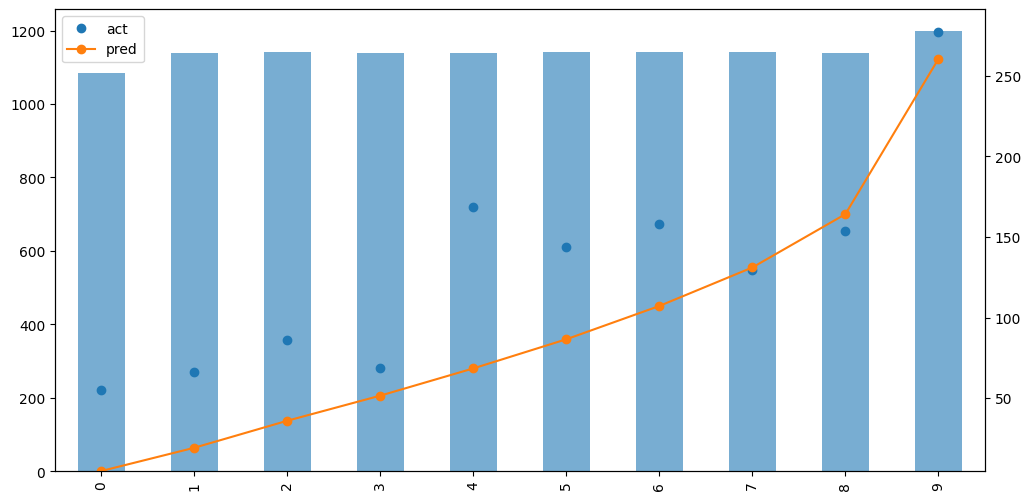

   decile   ee_col    act   pred
0    1.00 1,083.18  54.99   5.00
1    2.00 1,139.84  66.19  19.42
2    3.00 1,140.61  86.05  36.16
3    4.00 1,139.96  69.07  51.72
4    5.00 1,139.68 168.56  68.60
5    6.00 1,140.65 143.83  86.66
6    7.00 1,140.38 158.17 107.30
7    8.00 1,140.25 129.37 131.16
8    9.00 1,140.12 153.54 164.19
9   10.00 1,197.59 277.27 260.34


In [ ]:
easy_gbm(data1_train,data1_test,'ee_col',['ee_col','incloss_col','pp'],1.5,.10,6,base_score,50)

lift_chart(out_test, 'incloss_col', 'pred_loss', 'ee_col', 10)

## Hyperparameter tuning with cross validation

In [ ]:
# 5 fold CV with gridsearch & optimization metrics

def model_metrics(input_data, act, pred, weight_name):
    global x
    test_data = input_data.copy()
    bins = 50

    test_data['decile'] = (round(test_data.sort_values(by = 'pred')[weight_name].cumsum()/test_data[weight_name].sum(),2)*bins).apply(np.floor)
    test_data['decile'] = np.where(test_data['decile'] + 1 > bins ,bins,test_data['decile'] + 1)
    x = test_data.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()

    del test_data

    x['pp_act'] = x[act]/x[weight_name]
    x['pp_pred'] = x[pred]/x[weight_name]

    x['decile_error'] = abs(x['pp_pred']/x['pp_act'] - 1).replace(-np.inf, np.nan).replace(np.inf, np.nan).fillna(1)
    x['decile_error_sp'] = x['decile_error'] * x[weight_name]
    fit_quality = 1 - x['decile_error_sp'].sum()/x[weight_name].sum()

    tot_pp = x[act].sum()/x[weight_name].sum()
    x['diff_unity'] = abs(x['pp_pred']/tot_pp - 1)
    x['diff_unity'] = x['diff_unity'] * x[weight_name]
    model_power = x['diff_unity'].sum()/x[weight_name].sum()

    x.drop(columns = [act,pred], inplace = True)

    return_list = []
    return_list.append(model_power)
    return_list.append(fit_quality)
    return return_list

def mad_tt_split_cv_5_folds(data,fold_num):
    np.random.seed(seed=42)
    data['rand'] = np.random.randint(1, 101, data.shape[0])

    all_ints = [i for i in range(1, 101)]
    test_ints = [i for i in all_ints if i >= (fold_num-1) * 20 + 1 and i <= fold_num * 20]
    train_ints = [i for i in all_ints if i not in test_ints]

    global d1_train, d1_test
    d1_test = data.loc[data['rand'].isin(test_ints)].copy()
    d1_train = data.loc[data['rand'].isin(train_ints)].copy()

    del data['rand']

from IPython.display import clear_output

def cv_sub(act, pred, weight_name, drop_cols):
    global result_final
    result_temp = pd.DataFrame(columns = ['model_power','fit_quality','tweedie_p','bmf','max_depth','num_round'])
    for fold in [1,2,3,4,5]:
        mad_tt_split_cv_5_folds(data1_train.copy(),fold)
        for tweedie_p in tweedie_p_list:
            for bmf in bmf_list:
                for max_depth in max_depth_list:
                    for num_round in num_round_list:
                        easy_gbm(d1_train,d1_test,weight_name,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round)
                        result = pd.DataFrame(model_metrics(out_test, act, pred, weight_name)).T
                        result.columns = (['model_power','fit_quality'])
                        result['fit_quality'] = np.where(result['fit_quality'] < 0, 0, result['fit_quality']) # just in case we get negatives

                        result['tweedie_p'] = tweedie_p
                        result['bmf'] = bmf
                        result['max_depth'] = max_depth
                        result['num_round'] = num_round

                        result_temp = pd.concat([result_temp,result])

                        result_final = result_temp.groupby(['tweedie_p','bmf','max_depth','num_round']).agg({'model_power': 'mean', 'fit_quality': 'mean'}).reset_index()

                        clear_output()
                        fig = px.scatter(result_final, x='model_power', y='fit_quality', hover_data=['tweedie_p','bmf','max_depth','num_round'])
                        fig.show()

                        print('fold ' + str(fold) + ' params = ' + str(tweedie_p) + '_' + str(bmf) + '_' + str(max_depth) + '_' + str(num_round) + ' complete', end = '\r')

    # fig.write_html(save_path) # Doesn't work in colab but leaving here for reference


def lift_cv_5_folds(data,tweedie_p,bmf,max_depth,num_round,act, pred, drop_cols, weight_name = 'ee_col', bins = 10):
    x2 = pd.DataFrame()
    for fold in [1,2,3,4,5]:
        mad_tt_split_cv_5_folds(data.copy(),fold)

        easy_gbm(d1_train,d1_test,weight_name,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round)
        lift_data = out_test.copy()

        lift_data['decile'] = (round(lift_data.sort_values(by = 'pred')[weight_name].cumsum()/lift_data[weight_name].sum(),2)*bins).apply(np.floor)
        lift_data['decile'] = np.where(lift_data['decile'] + 1 > bins ,bins,lift_data['decile'] + 1)

        x = lift_data.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
        x2 = pd.concat([x2,x])
        print('fold ' + str(fold) + ' complete', end = '\r')

    dfg = x2.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    dfg['pp_act'] = dfg[act]/dfg[weight_name]
    dfg['pp_pred'] = dfg[pred]/dfg[weight_name]
    dfg.drop(columns = [act,pred], inplace = True)

    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()

    y_max = np.where(dfg['pp_act'].max() > dfg['pp_pred'].max(),dfg['pp_act'].max(),dfg['pp_pred'].max())*1.20
    ax2.set_ylim(0,y_max)

    dfg[weight_name].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['pp_act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='pp_act')
    dfg['pp_pred'].plot(kind='line', ax=ax2, marker='o', legend='pp_pred')
    plt.show()
    print(dfg[(['decile',weight_name,'pp_act','pp_pred'])])

In [ ]:
### Watch in action with just a small gridsearch
base_score = data1_train['incloss_col'].sum()/data1_train['ee_col'].sum()

drop_cols = ['ee_col','incloss_col','pp']

tweedie_p_list = [1.5]
bmf_list = [.05,.10]
max_depth_list = [6]
num_round_list = [25,50]

cv_sub('incloss_col','pred_loss','ee_col', drop_cols)

In [ ]:
# Next cell takes ~8 minutes to run

In [ ]:
base_score = data1_train['incloss_col'].sum()/data1_train['ee_col'].sum()

tweedie_p_list = [1.4,1.5,1.6]
bmf_list = [.05,.10,.20]
max_depth_list = [6,8,10]
num_round_list = [50,75,100]

cv_sub('incloss_col','pred_loss','ee_col', drop_cols)

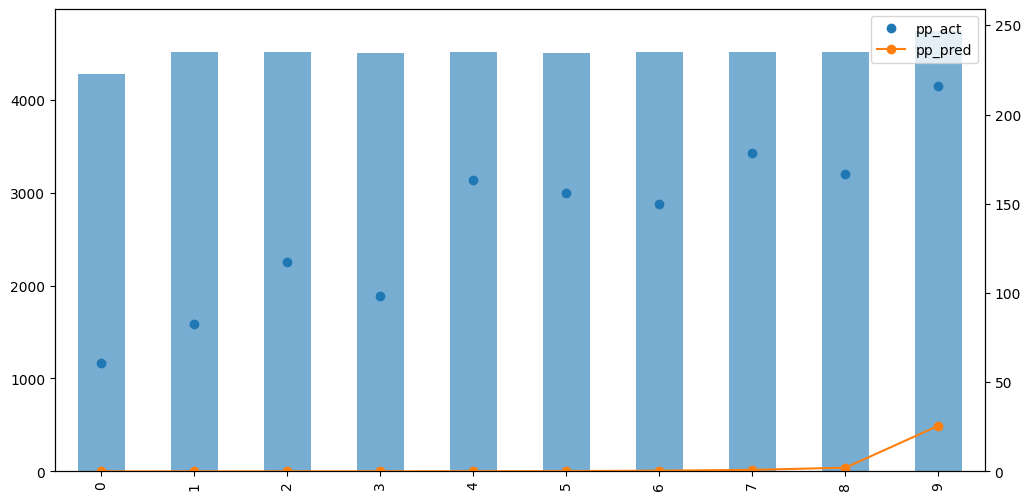

   decile   ee_col  pp_act  pp_pred
0    1.00 4,282.25   60.94     0.00
1    2.00 4,509.27   82.45     0.00
2    3.00 4,509.81  117.44     0.02
3    4.00 4,508.51   98.19     0.04
4    5.00 4,510.09  163.47     0.09
5    6.00 4,508.40  155.84     0.19
6    7.00 4,510.32  149.99     0.40
7    8.00 4,509.35  178.30     0.86
8    9.00 4,510.24  166.68     2.07
9   10.00 4,735.98  215.76    25.59


In [ ]:
# Review some top performers to narrow down search

### Most powerful
lift_cv_5_folds(data1_train, 1.4, .2, 10, 100, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col', bins = 10)

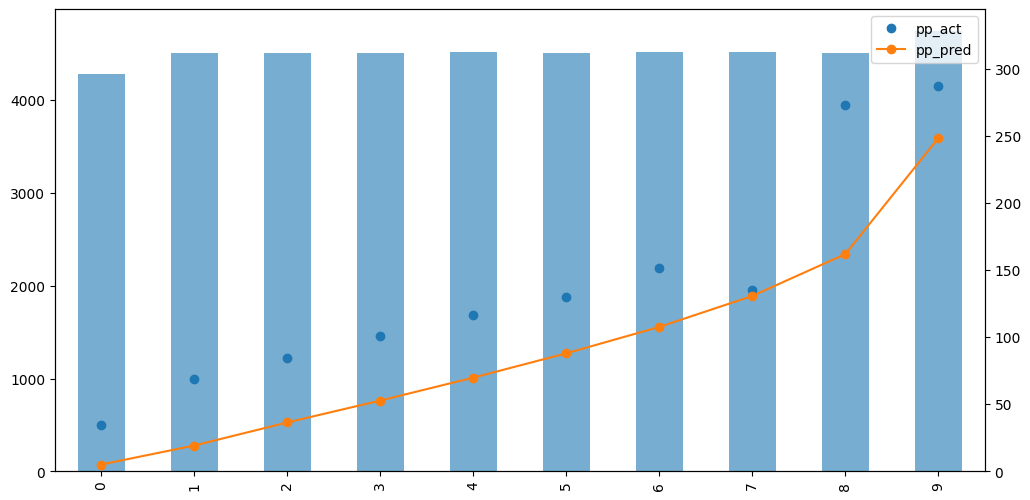

   decile   ee_col  pp_act  pp_pred
0    1.00 4,283.29   34.81     5.14
1    2.00 4,509.08   69.13    19.32
2    3.00 4,509.43   84.85    36.53
3    4.00 4,508.95  100.96    52.87
4    5.00 4,509.93  116.63    69.98
5    6.00 4,508.87  130.15    88.12
6    7.00 4,509.47  151.65   107.81
7    8.00 4,509.89  135.36   130.94
8    9.00 4,508.73  273.36   162.17
9   10.00 4,736.57  287.29   248.74


In [ ]:
### Best fit quality
lift_cv_5_folds(data1_train, 1.5, .05, 6, 75, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col', bins = 10)

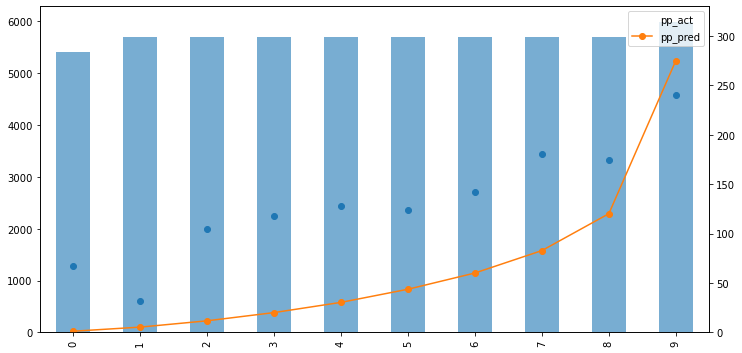

   decile   ee_col  pp_act  pp_pred
0    1.00 5,414.29   67.37     1.22
1    2.00 5,701.76   32.00     5.37
2    3.00 5,700.28  104.99    11.75
3    4.00 5,702.75  117.61    20.06
4    5.00 5,701.21  127.57    30.39
5    6.00 5,697.91  123.78    43.67
6    7.00 5,703.43  142.05    60.08
7    8.00 5,698.93  180.12    82.76
8    9.00 5,701.31  174.11   120.07
9   10.00 5,989.44  239.92   274.80


In [ ]:
### Blend
lift_cv_5_folds(data1_train, 1.4, .2, 6, 75, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col', bins = 10)

In [ ]:
# Iterations

In [ ]:
# Next cell takes ~5 minutes to run

In [ ]:
### Looks like we need to go for more conservative parameters and remove the 1.4 tweedie p as it seems to cause poor results

base_score = data1_train['incloss_col'].sum()/data1_train['ee_col'].sum()

tweedie_p_list = [1.5,1.6]
bmf_list = [.01,.03,.05]
max_depth_list = [2,4,6]
num_round_list = [25,50,75]

cv_sub('incloss_col','pred_loss','ee_col', drop_cols)

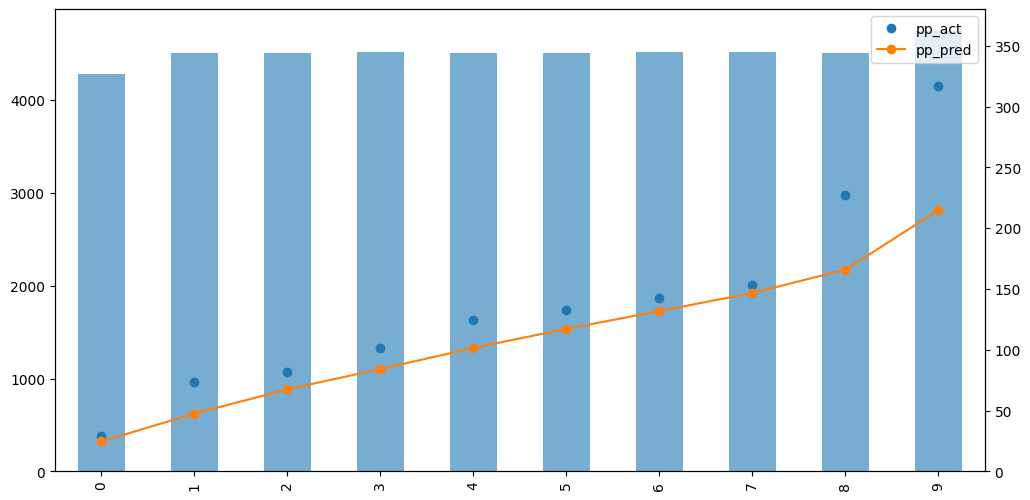

   decile   ee_col  pp_act  pp_pred
0    1.00 4,282.36   28.71    24.59
1    2.00 4,509.46   73.88    47.58
2    3.00 4,509.47   81.52    67.49
3    4.00 4,509.61  101.31    84.18
4    5.00 4,509.33  124.50   101.52
5    6.00 4,509.08  132.62   117.20
6    7.00 4,509.98  142.31   131.89
7    8.00 4,509.53  153.42   146.74
8    9.00 4,508.79  227.47   165.90
9   10.00 4,736.61  316.62   214.72


In [ ]:
# Option 1

lift_cv_5_folds(data1_train, 1.5, .05, 6, 25, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col', bins = 10)

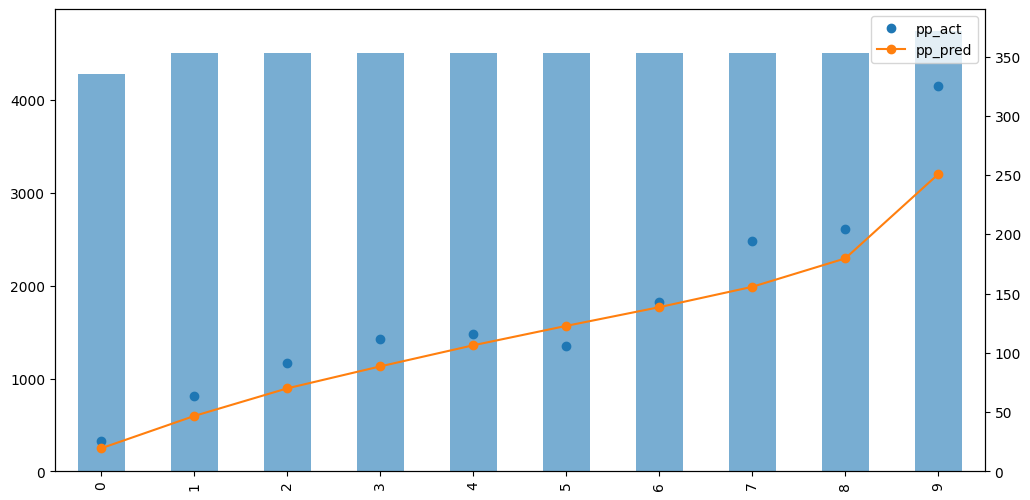

   decile   ee_col  pp_act  pp_pred
0    1.00 4,282.93   25.79    19.55
1    2.00 4,508.85   64.02    46.80
2    3.00 4,508.58   91.24    70.09
3    4.00 4,510.40  111.92    88.63
4    5.00 4,509.97  116.30   106.41
5    6.00 4,509.78  106.05   122.79
6    7.00 4,507.82  142.83   138.56
7    8.00 4,510.29  194.33   155.76
8    9.00 4,508.05  204.49   179.73
9   10.00 4,737.56  324.81   250.85


In [ ]:
# Option 2

lift_cv_5_folds(data1_train, 1.5, .05, 4, 50, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col', bins = 10)

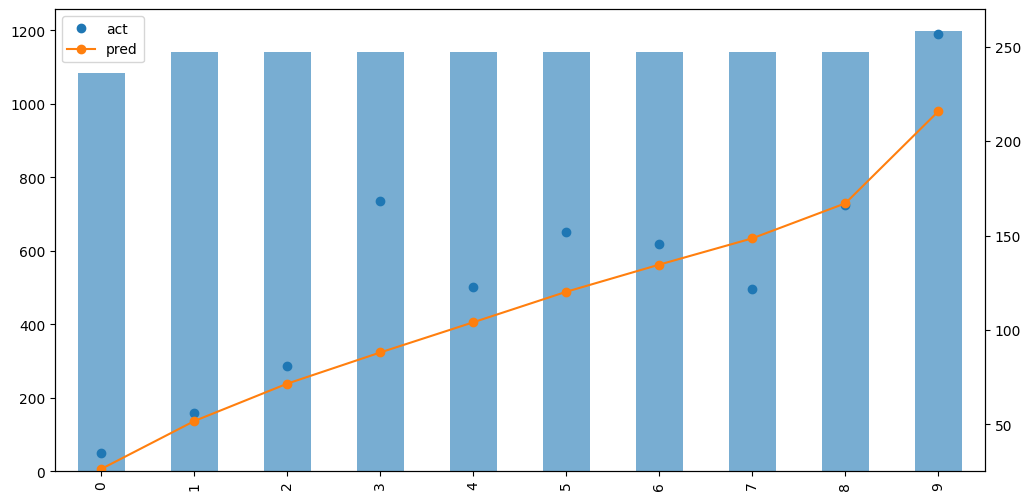

   decile   ee_col    act   pred
0    1.00 1,083.01  34.90  26.46
1    2.00 1,140.27  56.29  51.83
2    3.00 1,140.15  81.15  71.65
3    4.00 1,139.92 168.51  88.16
4    5.00 1,140.51 122.90 104.15
5    6.00 1,139.99 152.21 120.31
6    7.00 1,140.30 145.54 134.70
7    8.00 1,140.16 122.03 148.62
8    9.00 1,140.66 166.53 167.16
9   10.00 1,197.29 257.04 215.90


In [ ]:
# Review lift chart on test data to make final selection

# Go with option 1

easy_gbm(data1_train,data1_test,'ee_col',drop_cols,1.5,.05,6,base_score,25)

lift_chart(out_test, 'incloss_col', 'pred_loss', 'ee_col', 10)

## SHAP to evaluate model behavior

In [ ]:
# Next cell takes ~25 minutes to run

PermutationExplainer explainer: 16027it [26:14, 10.16it/s]                           


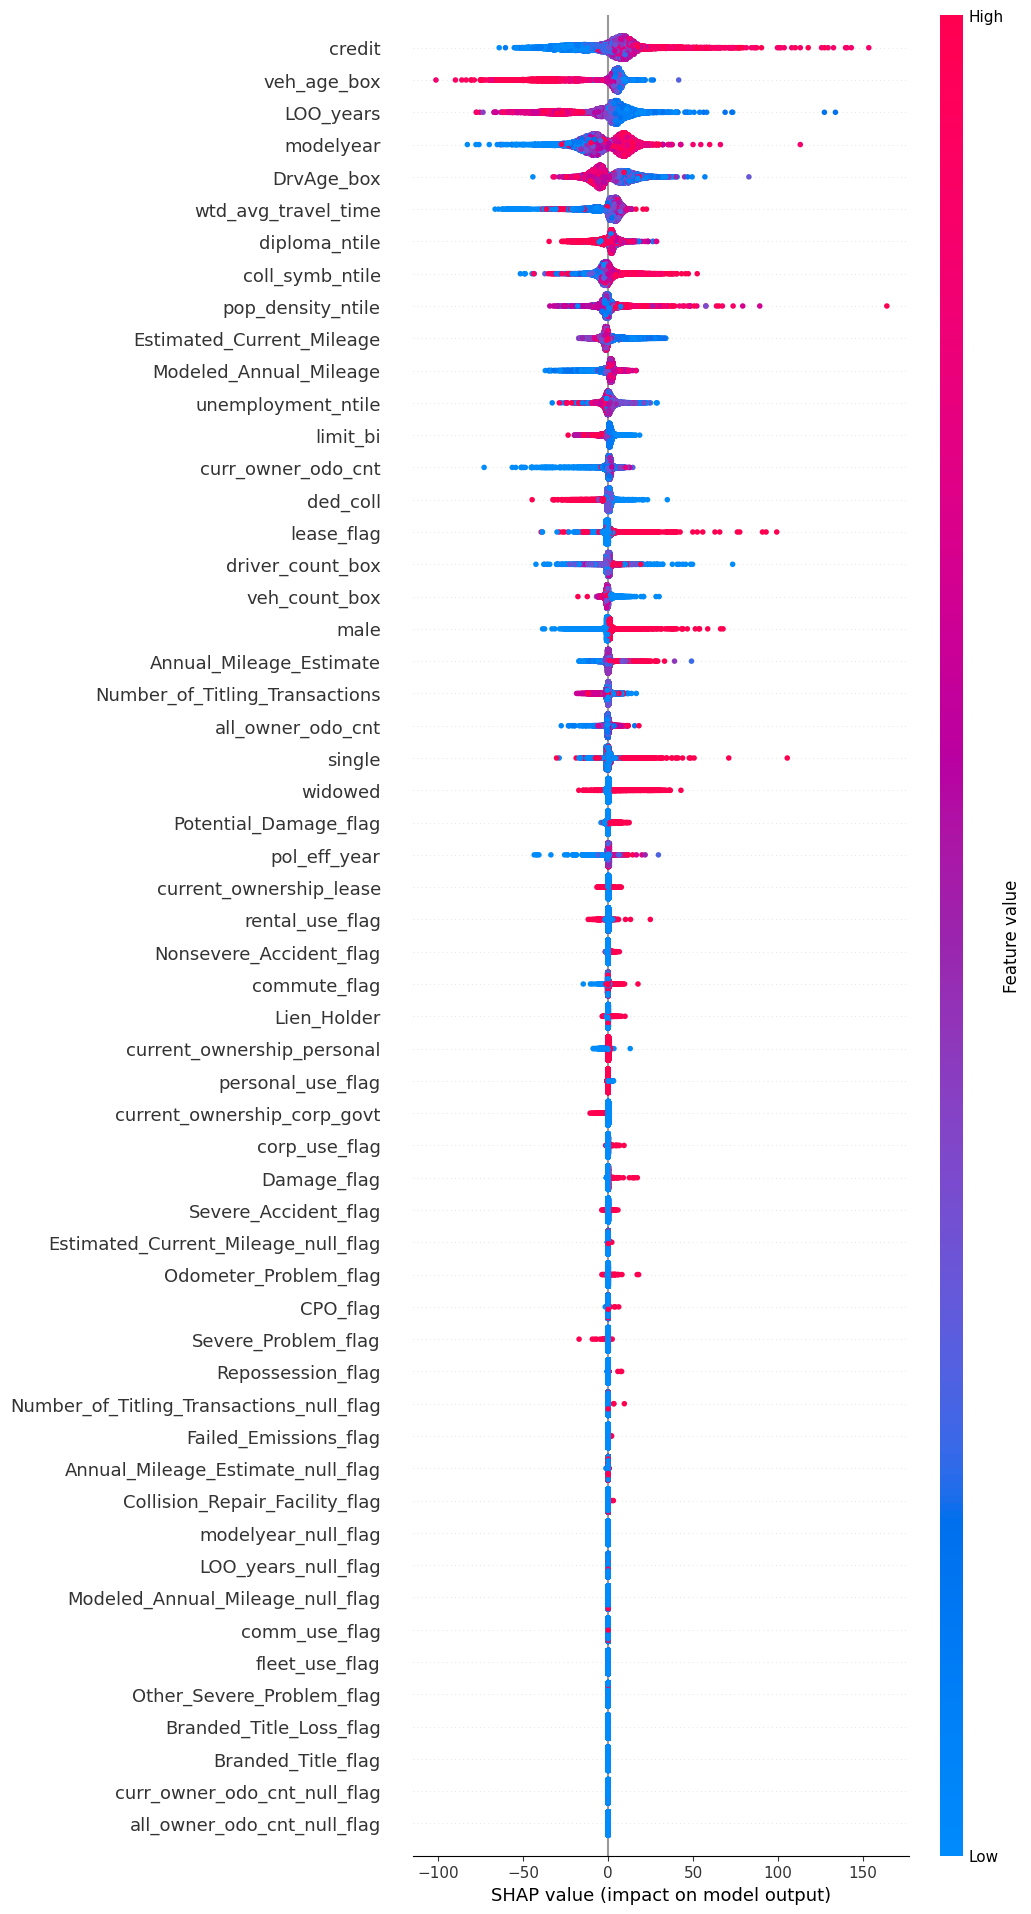

In [ ]:
# SHAP
def xgb_model_predict(data):
    dmatrix_data = xgb.DMatrix(data, feature_names=model_xgb.feature_names)
    return model_xgb.predict(dmatrix_data)

train_sample = data1_train[(model_xgb.feature_names)].sample(n = int(data1_train.shape[0]*.20))

background = shap.maskers.Independent(train_sample)
explainer = shap.Explainer(xgb_model_predict, background, approximate = True)
shap_values = explainer(train_sample)
shap.plots.beeswarm(shap_values, max_display = 999)

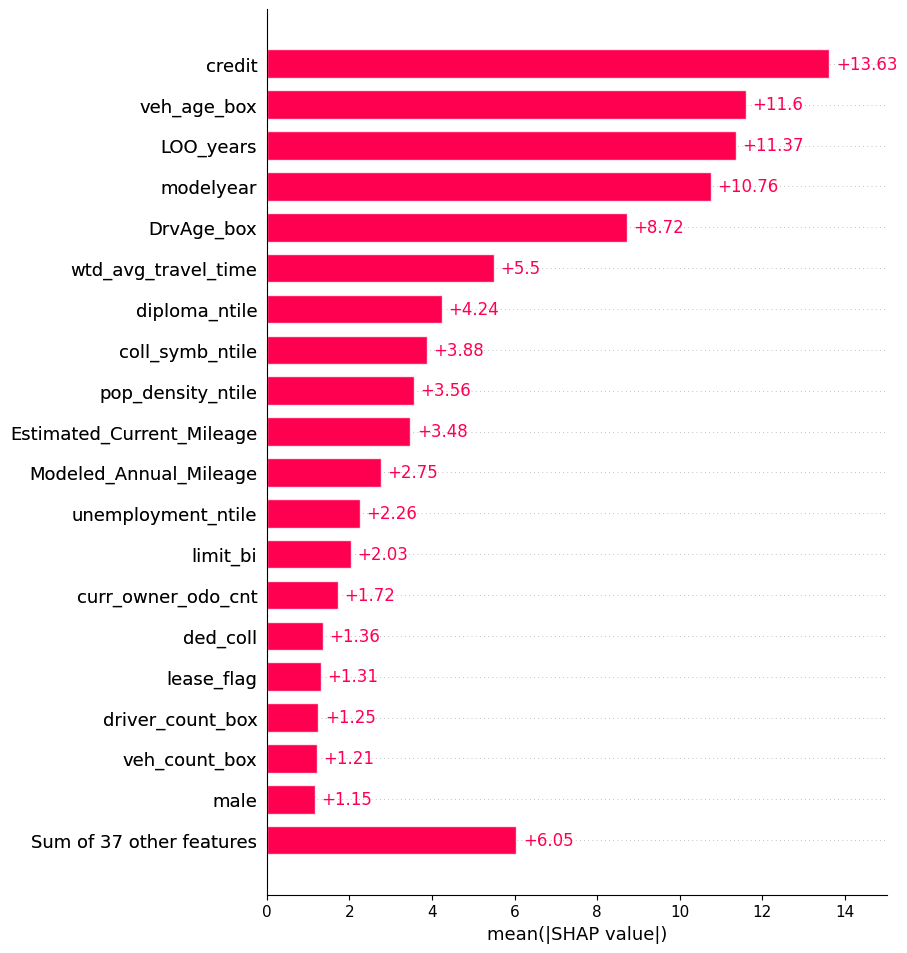

In [ ]:
# SHAP bar
shap.plots.bar(shap_values, max_display=20)

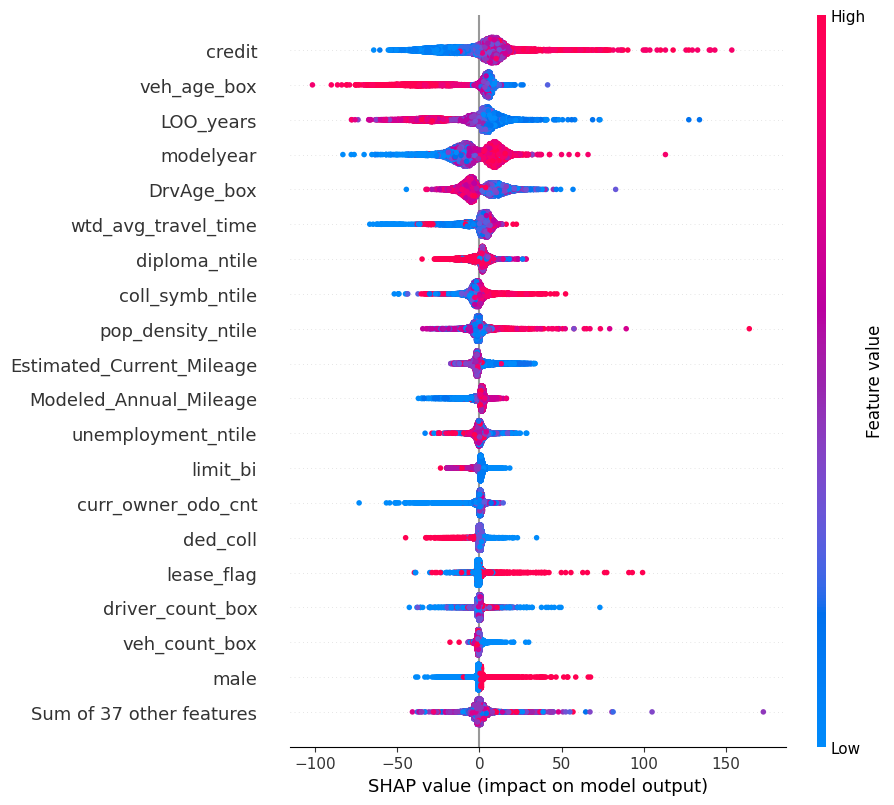

In [ ]:
# SHAP beeswarm
shap.plots.beeswarm(shap_values, max_display = 20)

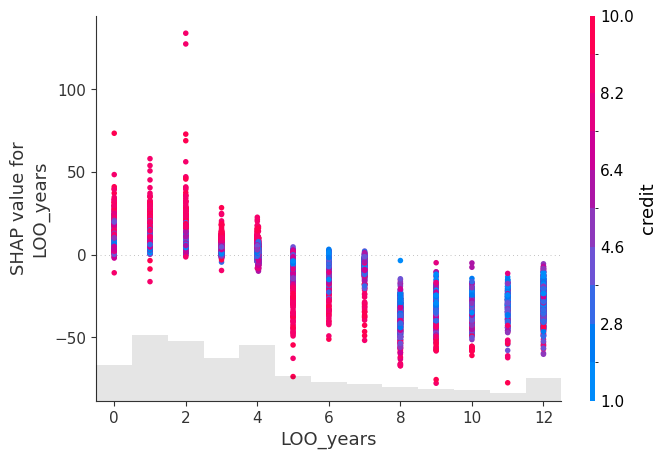

In [ ]:
# SHAP Scatter (codependence)

def shap_scatter_p1_p99(var,color_by):
    global a, b
    a = data1_train.groupby([var]).agg({'ee_col': 'sum'}).reset_index()
    a['cumsum'] = a['ee_col'].cumsum()
    a['ntile'] = round(a['cumsum']/a[len(a)-1:len(a)]['cumsum'].values,3)
    xmax = a.loc[a['ntile'] >= .99][0:1][var].values

    if a.loc[a['ntile'] <= .01][::][var].shape[0] == 0:
        xmin = a[0:1][var].values
    else:
        b = a.loc[a['ntile'] <= .01][::][var].copy()
        xmin = b[len(b)-1:len(b)].values

    x = shap_values[:, var]
    shap.plots.scatter(x
                       , color=shap_values[:,color_by]
                       , xmin=xmin
                       , xmax=xmax
                      )

shap_scatter_p1_p99('LOO_years','credit')

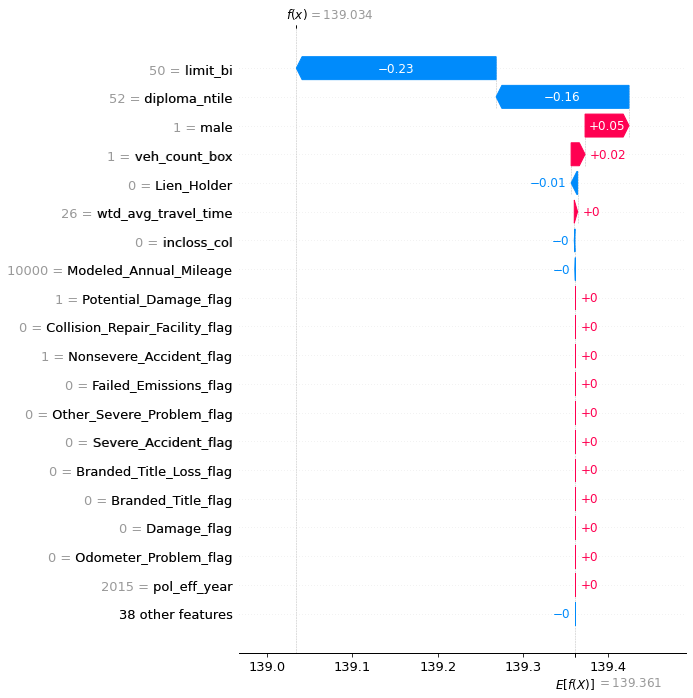

In [ ]:
# SHAP Waterfall (individual)
shap.plots.waterfall(shap_values[0], max_display = 20)

In [ ]:
model_xgb.trees_to_dataframe() # This is here for reference

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,veh_age_box,12.00,0-1,0-2,0-1,"77,839.09","532,962.69",NaN
1,0,1,0-1,credit,9.00,0-3,0-4,0-3,"44,050.09","450,062.69",NaN
2,0,2,0-2,LOO_years,7.50,0-5,0-6,0-5,"11,001.51","82,899.98",NaN
3,0,3,0-3,credit,3.00,0-7,0-8,0-7,"22,203.19","363,072.34",NaN
4,0,4,0-4,LOO_years,4.52,0-9,0-10,0-9,"18,306.02","86,990.37",NaN
...,...,...,...,...,...,...,...,...,...,...,...
4687,49,92,49-92,Leaf,NaN,NaN,NaN,NaN,-0.15,"2,291.33",NaN
4688,49,93,49-93,Leaf,NaN,NaN,NaN,NaN,0.08,"6,420.02",NaN
4689,49,94,49-94,Leaf,NaN,NaN,NaN,NaN,0.02,"46,098.93",NaN
4690,49,95,49-95,Leaf,NaN,NaN,NaN,NaN,0.10,"1,104.68",NaN


### Lesson 7 Exercise
#### As a group, discuss the SHAP Beeswarm plot.  Are the results reasonable?
#### As a group, call out any interactions that are worth discussion using the shap scatter plot

## Advice for explainable GBM in insurance applications
### Clip and bucket your feature levels until you have logical relationships that are monotonic in your one ways
### Set the same monotonicity for your model
### If the SHAP shows the model misbehaving, change your bucketing again